In [1]:
"""
Major Credit goes to Liam Schoneveld, whose work inspired this undertaking and heavily influenced 
my earlier trial and error, as well as the current work.

His site links:
https://nlml.github.io/neural-networks/detecting-bpm-neural-networks/
https://nlml.github.io/neural-networks/detecting-bpm-neural-networks-update/

The github repositories he posted:
https://github.com/nlml/bpm
https://github.com/nlml/bpm2

And his linkedIn:
https://www.linkedin.com/in/liam-schoneveld/
"""

# Our general imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Base packages used
import keras

# Specific neural network models & layer types
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.layers import Reshape
from keras.callbacks import EarlyStopping
from keras.models import load_model
# To seperate our data into test and validation
from sklearn.model_selection import train_test_split


# A wonderful library for audio in python
import librosa
# To display waveforms and spectrograms
import librosa.display

# To listen to tunes
import IPython.display as ipd

# To find bpm
import re

# To get samples
import random

# To save our data!
from sklearn.externals import joblib

# To resize the spectrogram!
import cv2

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Data Creation
# This is toy data with toy responses, to see if the concept works.
def makedf(trackpath="WaveBank/one_80.wav", samples = 10):
    
    """
    Make df accepts wav files of my specific naming structures. It then:
        1. Normalizes the track
        2. Checks the bpm
        3. Creates the y-variable category, the bpm
        4. Takes random 4 second slices to create a dataframe.
    """
    
    
    
    # Our X and y to make a dataframe
    X = []
    y = []
    
    # Take the track and get the array
    wav, sr = librosa.load(trackpath, sr=44100)
    
    # Normalize the track
    wav = wav / np.max(wav)
    
    # Check for bpm as our target category.
    target = int(re.findall(r"\d{1,3}", trackpath)[0])
    
    # This is to put the bpm into the range that makes sense to us.
    if target > 160:
        target = int(target/2)
    elif target < 80:
        target = int(target*2)
    
    # Create a list index where the categories should go
    category_list = list(np.arange(80,161))
    
    # Give the y_value the number of the indexed bpm, to work for sparse categorical entropy
    y_target = category_list.index(target)
    
    # To make the desired samples
    s = 0
    while s < (samples):
        
        # Make random slices
        s += 1
        
        # Randomize the slice
        start = random.randint(0,(len(wav)-(sr*4)))
        x_slice = wav[start:(start+(sr*4))]
        
        # To downsample our x_slice
        x_slice = x_slice[0::4]
        
        # Reshape our wav to a 441 time steps with 100 feature matrix
        x_slice = x_slice.reshape(441,100)
        
        # Add the matrices to our list
        X.append(x_slice)
        y.append(y_target)
    
    # Change our lists into arrays
    X = np.array(X)
    y = np.array(y)
    
    # Give us the data!
    return X, y

In [3]:
# Make a big data set 
# for BigBrainBeatv3_phase2
for i in range(80,161):
    X, y = makedf(trackpath=f"WaveBank/two_{i}.wav", samples = 150)
    if i == 80:
        X_totalv3_phase2 = X
        y_totalv3_phase2 = y
        print(X_totalv3_phase2.shape)
        print(y_totalv3_phase2.shape)
    else:
        X_totalv3_phase2 = np.append(X_totalv3_phase2, X, axis = 0)
        y_totalv3_phase2 = np.append(y_totalv3_phase2, y, axis = 0)

        # This is if we want to save our dataset for later
#     joblib.dump(X_total, "X_totalv3_phase2.pkl")
#     joblib.dump(y_total, "y_totalv3_phase2.pkl")
   
print(X_totalv3_phase2.shape)
print(y_totalv3_phase2.shape)

(150, 441, 100)
(150,)
(12150, 441, 100)
(12150,)


In [4]:
# Now we split our data
X_train, X_test,y_train, y_test = train_test_split(X_totalv3_phase2, y_totalv3_phase2, test_size = 0.40)

In [5]:
# To check and see if everything is in the desired shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7290, 441, 100)
(4860, 441, 100)
(7290,)
(4860,)


In [6]:
# To normalize the data, between 0 and 1
X_train /= X_train.max()
X_test /= X_train.max()

In [7]:
# To create our re-imagined convolution neural network

category_list = list(np.arange(80,161))
input_rows = X_train.shape[1]
input_feat = X_train.shape[2]
num_classes = len(category_list)

# Using AWS we can run more epochs, so let's get crazy and see how far we can go!
early = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

# To bring in our convolution Neural Network, and train on more, new, different data!
BigBrainBeatv3_phase2 = load_model('BigBrainBeatv3_phase1.h5')
BigBrainBeatv3_phase2.summary()

W0901 22:19:48.978662 140103980910400 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 22:19:49.001198 140103980910400 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 22:19:49.020564 140103980910400 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 22:19:49.021341 140103980910400 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 441, 10)           3010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 441, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 441, 10)           510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 441, 10)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4410)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 81)                357291    
_________________________________________________________________
dropout_3 (Dropout)          (None, 81)                0         
__________

In [8]:
# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation on the test data after each batch
BigBrainBeatv3_phase2.fit(X_train, y_train,
              batch_size = 50,
              epochs = 50,
              verbose = 1,
              validation_data = (X_test, y_test),
              shuffle=True,
              callbacks=[early])

Train on 7290 samples, validate on 4860 samples
Epoch 1/50
7290/7290 [==============================] - 7s 949us/step - loss: 4.3917 - acc: 0.0177 - val_loss: 4.3800 - val_acc: 0.0208
Epoch 2/50
7290/7290 [==============================] - 6s 812us/step - loss: 4.3763 - acc: 0.0222 - val_loss: 4.3570 - val_acc: 0.0267
Epoch 3/50
7290/7290 [==============================] - 6s 808us/step - loss: 4.3023 - acc: 0.0248 - val_loss: 4.0857 - val_acc: 0.0467
Epoch 4/50
7290/7290 [==============================] - 6s 808us/step - loss: 4.1330 - acc: 0.0447 - val_loss: 3.9412 - val_acc: 0.0720
Epoch 5/50
7290/7290 [==============================] - 6s 815us/step - loss: 4.0251 - acc: 0.0457 - val_loss: 3.8039 - val_acc: 0.0971
Epoch 6/50
7290/7290 [==============================] - 6s 813us/step - loss: 3.8538 - acc: 0.0684 - val_loss: 3.4604 - val_acc: 0.1461
Epoch 7/50
7290/7290 [==============================] - 6s 808us/step - loss: 3.6435 - acc: 0.0835 - val_loss: 3.1491 - val_acc: 0.1955


In [9]:
# Evaluate the model's performance on the test data
score = BigBrainBeatv3_phase2.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

4860/4860 [==============================] - 1s 237us/step
Test loss: 1.3281751154872126
Test accuracy: 0.5907407408879127


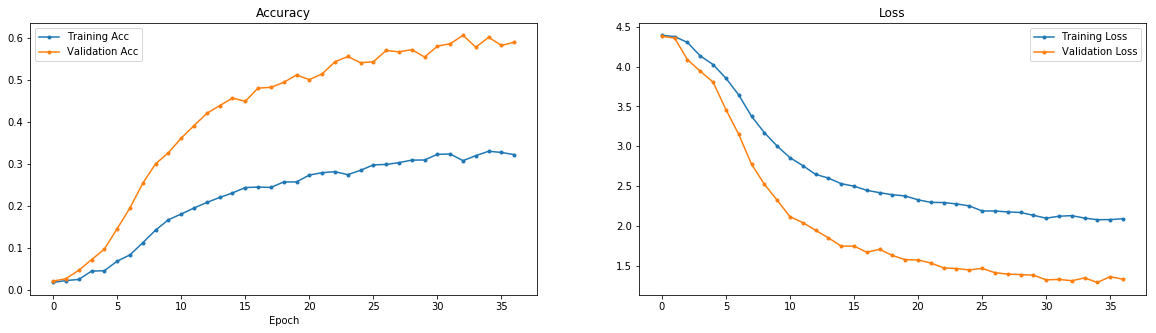

<Figure size 432x288 with 0 Axes>

In [10]:
# Get the training history 
history = BigBrainBeatv3_phase2.history 

# Accuracy and loss for test set
acc = history.history['acc']
loss = history.history['loss']

# Accuracy and loss for validation set
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# Accuracy
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Acc', marker='.')
plt.plot(val_acc, label='Validation Acc', marker='.')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss', marker='.')
plt.plot(val_loss, label='Validation Loss', marker='.')
plt.title('Loss')
plt.legend()

plt.savefig("BigBrainBeatv3_phase2_accAndLoss.jpg")

plt.show()

In [11]:
# To save our model
BigBrainBeatv3_phase2.save('BigBrainBeatv3_phase2.h5')

In [12]:
# To write the history to a text file
BigBrainBeatv3_phase2_history = open("BigBrainBeatv3_phase2_history.txt","w+")
history_string = str(history.history)
BigBrainBeatv3_phase2_history.write(history_string)

2997

___
Let's now see if we can approximate the position of the beats based on our predicted bpm, as well as visualize this outcome.

In [40]:
# A function to read in a wav, take the first four seconds, then arrange it to do a prediction
def new_wav_slice(trackpath = "Teleportoise - Epilogue.wav", start = 0):
    """
    This function takes in a wav filepath.
    It then takes the 4 second slice of the wav, starting at the specified second.
    It downsamples the 4 second wav by a quarter. When playing the wav back, 
    the specified sampling rate ought to be 11025.
    It reshapes this slice into a matrix to be used for our model.
    It returns the wav in the shape we want for our model.
    """
    
    # To read in the wav
    wav, sr = librosa.load(trackpath, sr=44100)
    
    # To normalize the wav
    wav = wav / np.max(wav)
    
    start = sr*start
    
    # To take our desired slice
    x_slice = wav[start:(start+(sr*4))]
        
    # To downsample our x_slice
    x_slice = x_slice[0::4]
    
    # To reshape into what we want for the model
    matrix = x_slice.reshape(1, 441, 100)
    
    return matrix

In [41]:
def graph_pred(three_d_mat, model):    
    """
    This function takes in a matrix shape(1, 441, 100), and our model.
    The matrix should represent a 4 second 44100hz wav, downsampled to 11025hz and reshaped.
    This function then predicts a bpm based on the range our model has been provided.
    It returns a beat prediction array as well a flattening of the wave matrix to compare in a graph.
    """
    # To get our flattened file for later.
    downsampled_wav = three_d_mat.flatten()
    
    
    # A list of possible bpm values
    category_list = list(np.arange(80,161))

    # The liklihoods of different bpm values our model is guessing for the image
    predictions_index = np.argmax(model.predict(three_d_mat))
    
    print(f"Our predicted bpm is:{category_list[predictions_index]}")

    # Get the beats per second
    bps = category_list[predictions_index]/60

    # To find how many hertz between each beat
    beat_step = int(11025/bps)

    # In our model and how we process the data at least one beat MUST fall within this range.
    max_check_range = int(11025/(80/60))

    # Setting up our beat illustrater
    beat_pred = np.zeros(44100)

    # Getting the index from where to start the beat inference
    index_start = np.argmax(downsampled_wav[0:max_check_range])
    
    # To write in where we are inferring the beats should be based on predicition
    for i in range(index_start,44101,beat_step):
        beat_pred[i-1] = 1
    
    
    return beat_pred, downsampled_wav

In [42]:
matrix = new_wav_slice(trackpath = "WaveBank/two_143.wav")
beat_pred, downsampled_wav = graph_pred(matrix, BigBrainBeatv3_phase2)

Our predicted bpm is:144


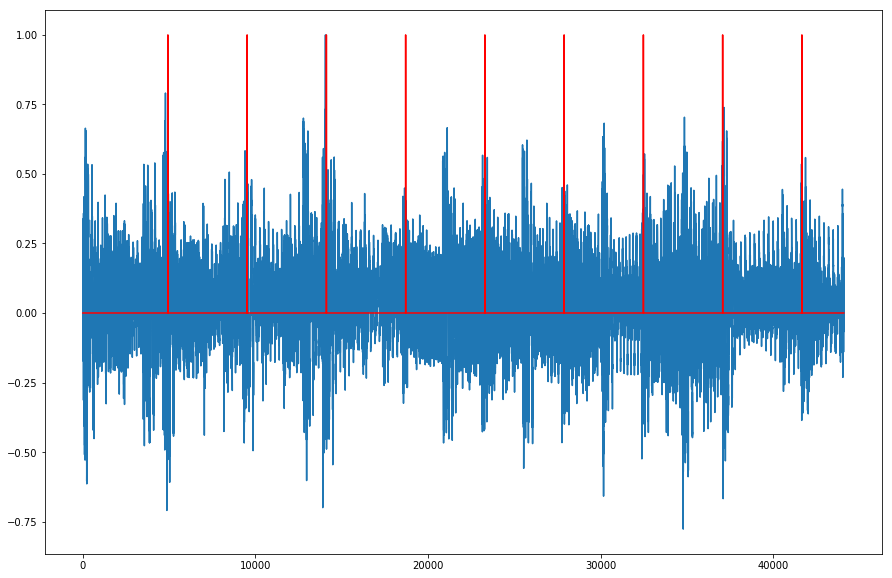

In [43]:
plt.figure(figsize=(15,10))
plt.plot(downsampled_wav)
plt.plot(beat_pred, "red")
plt.show()

In [1]:
# And to listen to the tune, make sure the sampling rate is correct!
ipd.Audio(data = (downsampled_wav,beat_pred), rate =11025)

NameError: name 'ipd' is not defined